<a href="https://colab.research.google.com/github/chrisrichardson/intrusion-thermal/blob/main/Thermal_Intrusion_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded


In [34]:
def keff(T):
    '''
    Calculate effective value of diffusivity as
    a function of temperature taking into account Latent Heat of Fusion
    kappa = k / rho [ Cp + L/deltaT ]
    Typical values:
    Density rho = 3000 kg/m3
    Thermal conductivity k = 3 W/m/K
    Heat capacity Cp = 1000 J/kg/K
    Latent heat of fusion L = 500000 J/kg
    Melting interval deltaT = 200 K
    '''

    # Melting point
    Tm = 1000

    # ratio L/(Cp * deltaT)
    L_CpdT = 2.1

    # Relative value for k
    keff = 1.0 / (1.0 + L_CpdT * (T > Tm))
    return keff

In [15]:
def matA(T, gam, hold):
    ''' Discretisation of the diffusion equation:
    dT/dt = k(T) d2T/dx2
    using a backward-Euler method in 1D, resulting in a
    tridiagonal matrix system A.T(n+1) = T(n).
    Use a tridiagonal solver (e.g. scipy solve_banded).
    Boundary conditions are set to zero flux at x=0 (i.e. symmetric)
    and to fixed T on the other edge of the domain.
    '''
    nr = len(T)
    k = keff(T)
    A = np.zeros((3, nr))

    if (hold > 0):
      k[:hold] = 0.0

    # B.C. at x=0, no flux.
    A[0, 1] = -1.0 * gam * k[0]
    A[1, 0] = 1.0 + 1.0 * gam * k[0]

    A[0, 2:nr] = -gam * k[1:nr - 1]
    A[1, 1:nr - 1] = 1.0 + 2.0 * gam * k[1:nr - 1]
    A[2, 0:nr - 2] = -gam * k[1:nr - 1]


    # B.C. at x=nr*dx, fixed T
    A[1, nr - 1] = 1.0
    A[2, nr - 2] = 0.0

    return A


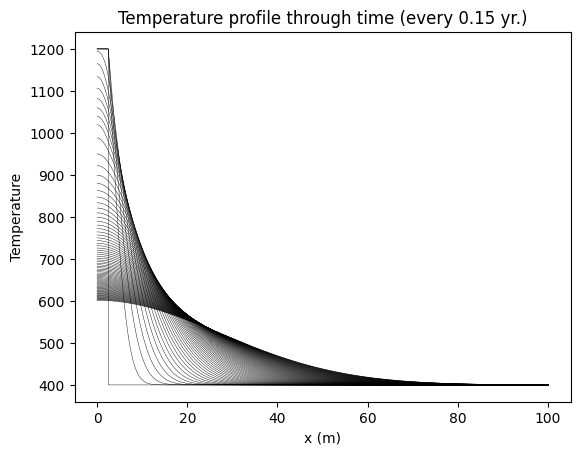

In [32]:
# Set up problem

# Full width of intrusion (m)
w = 5.0

# initial temperature of intrusion (C)
T0 = 1200.0

# melting point
Tm = 1000.0

# background temperature (C)
Tinf = 400.0

# Thermal diffusivity (m^2/s)
kappa = 1e-6

# Hold time (years)
t_hold = .5

# Use nw points for the intrusion half-width
nw = 100

# Use n points for the total problem
n = 4000

# Position (from centre) to take sample (x)
xs = 2.6

# Initial conditions
T = np.zeros(n)
T[0:nw] = T0
T[nw:] = Tinf

dx = w/(2*nw)
ns = int(xs/dx)
x = np.arange(0, len(T) * dx, dx)

# Timestep in years
dt_years = 0.003

# Timestep in seconds
sec_per_year = 365.0 * 24.0 * 3600.0
dt = dt_years * sec_per_year

# Dimensionless timestep
gam = kappa * dt/dx/dx

# Store time at which temperature goes below Tm
cool_time = np.zeros_like(T)

# Store sampled T and t
ns_store = []
tyr = []

# Initialise
t = 0.0
i = 0
iplot = 50
hold = nw
# Stop when the sampled T is below 600 and centre is below Tm.
while(T[ns] > 600 or T[0] > Tm):

  ns_store += [T[ns]]
  tyr += [t/sec_per_year]

  if (i % iplot == 0):
    plt.plot(x, T, color='k', lw=0.3)

  # Hold nw points at fixed T until after time t_hold
  if (t/sec_per_year > t_hold):
    hold = 0

  # Update solution
  A = matA(T, gam, hold)
  T = solve_banded((1, 1), A, T)
  cool_time[np.where(T > Tm)] = t/sec_per_year
  t += dt
  i += 1

plt.xlabel('x (m)')
plt.ylabel('Temperature')
plt.title(f"Temperature profile through time (every {iplot*dt_years} yr.)")
plt.show()

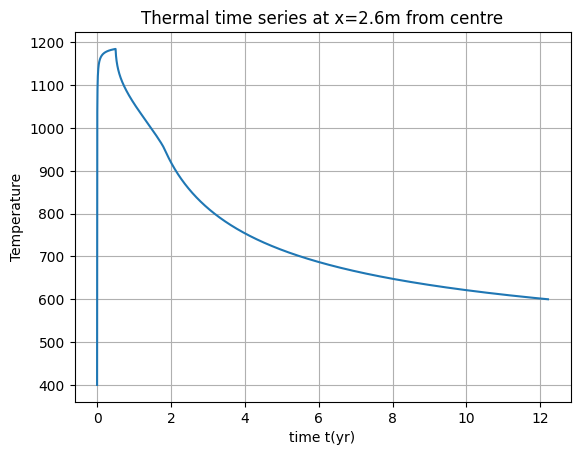

(0.0, 5.0)

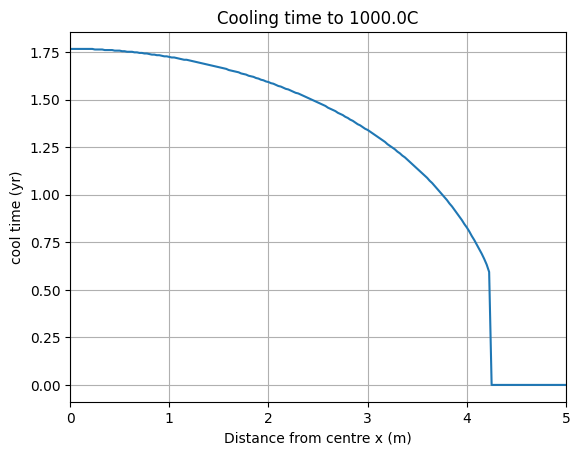

In [33]:
plt.plot(tyr, ns_store)
plt.grid()
plt.xlabel("time t(yr)")
plt.ylabel("Temperature")
plt.title(f"Thermal time series at x={xs}m from centre")
plt.show()

plt.plot(x, cool_time)
plt.grid()
plt.xlabel('Distance from centre x (m)')
plt.ylabel('cool time (yr)')
plt.title(f"Cooling time to {Tm}C")
plt.xlim(0, w)